In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob


class VisualizeCam():
    def __init__(self, model_paths, img_paths, IMG_SIZE):
        self.model_paths = model_paths
        self.model_dict = self.extract_models()
        self.img_paths = img_paths
        self.IMG_SIZE = IMG_SIZE
        self.model = True
    
    ## 테스트 이미지 랜덤 선택  끝
    def random_load_test_images(self, iter_num=1):
        
        img_paths = glob(os.path.join(self.img_paths, '*_*', '*'))

        if iter_num != 1:
            imgs, labels = [], []
            paths = np.random.choice(img_paths, iter_num, replace=False)
            for path in paths :
                img = tf.io.read_file(path)
                img = tf.image.decode_image(img, channels=3, expand_animations=False)
                img = tf.image.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                label = int(path.split('/')[-2].split('_')[-1])
                imgs.append(img)
                labels.append(labl)

            return imgs, labels

        else :
            path = np.random.choice(img_paths, 1, replace=False)[0]
            # print(path)
            img = tf.io.read_file(path)
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
            img = tf.image.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

            label = int(path.split('/')[-2].split('_')[-1])
        
            return img, label
    
    ## 경로로부터 학습시킨 모델들을 dict에 담아서 return  완성
    def extract_models(self):
        
        models = os.listdir(self.model_paths)
        models = [x for x in models if 'ipynb' not in x]
        models = [x for x in models if 'EfficientNet' in x]
        models = list(map(lambda x : '_'.join(x.split('_')[:-1]), models))
        model_dict = {}
        for idx, model_name in enumerate(models):
            model_dict[idx] = model_name
        
        return model_dict


    def load_model(self):
    # load_model호출

        models_dirs = glob(os.path.join(self.model_paths, "*"))
        models_dirs = [x for x in models_dirs if 'ipynb' not in x]
        models_dirs = [x for x in models_dirs if 'EfficientNet' in x]
        print(f'사용가능한 모델\n{self.model_dict}')
        model_num = int(input('사용할 모델의 번호 입력 : '))
        model_name = self.model_dict[model_num]

        for models_dir in models_dirs:
            if model_name in models_dir :
                target = models_dir
    
        trained_models = glob(os.path.join(target, '*-*-*.h5'))
        trained_models = sorted(trained_models, key=lambda x : os.path.basename(x).split('-')[-1], reverse=True)  # 정확도 기준, 내림차순 정렬
        print('Model 불러오는 중...')
        target_model = tf.keras.models.load_model(trained_models[0]) # 가장 정확도가 높은 모델을 load
        print(f'불러온 모델의 경로 : {trained_models[0]}')
        print('완료\n')
        self.model = target_model

        return target_model
    
    def generate_grad_cam(self, img, label):
        width = img.shape[1]
        height = img.shape[0]

        x = self.model.layers[0].layers[-1].output
        img_output = x
        
        l = self.model.layers[0].layers[-1].output
        # lbl_output = l
        l = tf.keras.layers.GlobalAveragePooling2D()(l)
        l = self.model.layers[-2](l)
        lbl_output = self.model.layers[-1](l)
        # l = tf.keras.layers.Dense(512, activation='relu')(l)
        # lbl_output = tf.keras.layers.Dense(30, activation='softmax')(l)

        grad_model = tf.keras.models.Model(inputs=[self.model.layers[0].inputs], outputs=[img_output, lbl_output])
    
        with tf.GradientTape() as tape:
            conv_output, pred = grad_model(tf.expand_dims(img, 0))
            loss = pred[:, label]
            output = conv_output[0]

            grad_val = tape.gradient(loss, conv_output)[0]

        weights = np.mean(grad_val, axis=(0, 1))  # GAP 연산
        grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
        for k, w in enumerate(weights):
            grad_cam_image += w * output[:, :, k]
        
        grad_cam_image /= np.max(grad_cam_image)
        grad_cam_image = grad_cam_image.numpy()
        grad_cam_image = cv2.resize(grad_cam_image, (width, height))

        return grad_cam_image, pred



    def generate_cam(self, img, label):
        width = img.shape[1]
        height = img.shape[0]

        x = self.model.layers[0].layers[-1].output
        img_output = x
        # x = tf.keras.layers.GlobalAveragePooling2D()(x)
        # img_output = tf.keras.layers.ReLU()(x)

        l = self.model.layers[0].layers[-1].output
        l = tf.keras.layers.Flatten()(l)
        l = tf.keras.layers.Dense(512, activation='relu')(l)
        lbl_output = tf.keras.layers.Dense(30, activation='softmax')(l)
        
        cam_model = tf.keras.models.Model(inputs=[self.model.layers[0].inputs], outputs=[img_output, lbl_output])

        conv_outputs, predictions = cam_model(tf.expand_dims(img, 0))

        conv_outputs = conv_outputs[0, :, :, :]
        class_weights = model.layers[-1].get_weights()[0]

        cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
        for i, w in enumerate(class_weights[:, lbl]):
            cam_image += w * conv_outputs[:, :, i]
        
        cam_image /= np.max(cam_image)
        cam_image = cam_image.numpy()
        cam_image = cv2.resize(cam_image, (width, height))

        return cam_image, label
    
    def visualize_cam_on_image(self, cam, origin, alpha=0.5) :
        

        plt.figure(figsize=(15, 5))
        
        # plt.suptitle(f'원본이미지 / Grad-CAM / 원본+Grad-CAM')
        plt.subplot(131)
        plt.title('origin')
        plt.imshow(np.uint8(origin))
        plt.subplot(132)
        plt.title('Grad-CAM')
        plt.imshow(cam)

        origin_image = origin.numpy().astype(np.uint8)
        # cam_image_3channel = np.stack([cam*255]*3, axis=-1).astype(np.uint8)
        beta = (1.0 - alpha)
        cam_image_int = np.uint8(255 * cam)
        heatmap = cv2.applyColorMap(cam_image_int, cv2.COLORMAP_JET)
        merged_image = cv2.addWeighted(heatmap, alpha, origin_image , beta, 0.0)

        plt.subplot(133)
        plt.title('merged image')
        plt.imshow(merged_image)
        plt.colorbar()
        plt.show()


In [ ]:
model.layers[-2:]

In [ ]:
model_path = '/content/drive/Shareddrives/GOFOODA/data/models'
img_paths ='/content/drive/Shareddrives/GOFOODA/data/test_image'

In [ ]:
VC = VisualizeCam(model_paths=model_path, img_paths=img_paths, IMG_SIZE=360)

In [ ]:
model = VC.load_model()

사용가능한 모델
{0: 'EfficientNetB0', 1: 'EfficientNetB1', 2: 'EfficientNetB0_aug', 3: 'EfficientNetB0_alb', 4: 'EfficientNetB2', 5: 'EfficientNetB3', 6: 'EfficientNetB4'}
사용할 모델의 번호 입력 : 3
Model 불러오는 중...
불러온 모델의 경로 : /content/drive/Shareddrives/GOFOODA/data/models/EfficientNetB0_alb_checkpoint/alb_73-0.01-1.00.h5
완료



In [ ]:
test_img, test_label = VC.random_load_test_images()

In [ ]:
cam_image, _ = VC.generate_grad_cam(test_img, test_label)

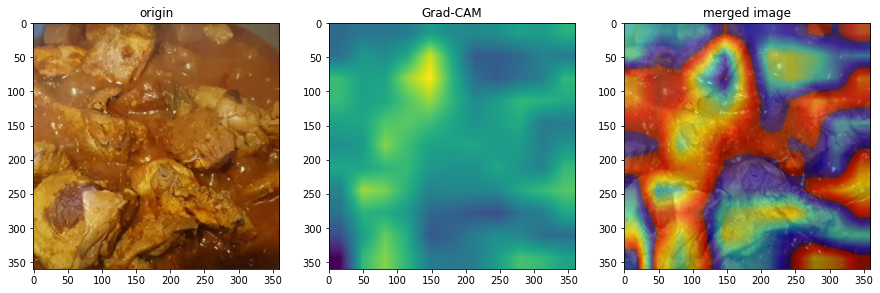

In [ ]:
VC.visualize_cam_on_image(cam_image, test_img)

In [ ]:
c_test_paths = glob('/content/drive/Shareddrives/GOFOODA/data/cam_test/*')
c_test_paths

['/content/drive/Shareddrives/GOFOODA/data/cam_test/돈까스라면.jpg',
 '/content/drive/Shareddrives/GOFOODA/data/cam_test/반반치킨.jpg',
 '/content/drive/Shareddrives/GOFOODA/data/cam_test/짬짜탕.jpg',
 '/content/drive/Shareddrives/GOFOODA/data/cam_test/피자치킨.jpg',
 '/content/drive/Shareddrives/GOFOODA/data/cam_test/짜탕짜.jpg']

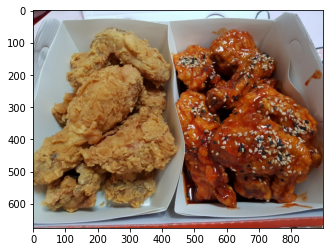

In [ ]:
c_test = tf.io.read_file(c_test_paths[1])
c_test = tf.image.decode_image(c_test, channels=3, expand_animations=False)
plt.imshow(c_test)

In [ ]:
c_test = tf.image.resize(c_test, (360, 360))

In [ ]:
yang, y_label = VC.generate_grad_cam(c_test, 21)

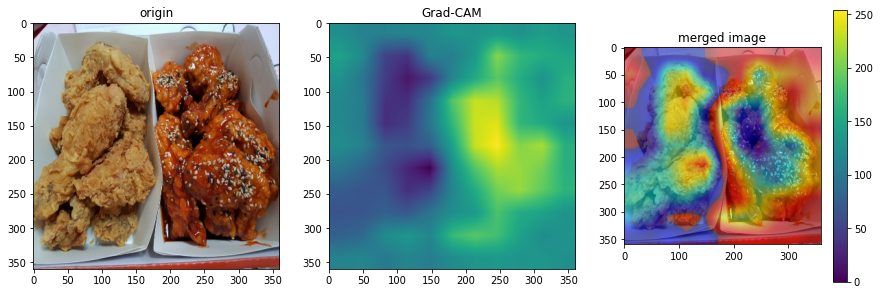

In [ ]:
VC.visualize_cam_on_image(yang, c_test)

In [ ]:
fried, f_label = VC.generate_grad_cam(c_test, 29)

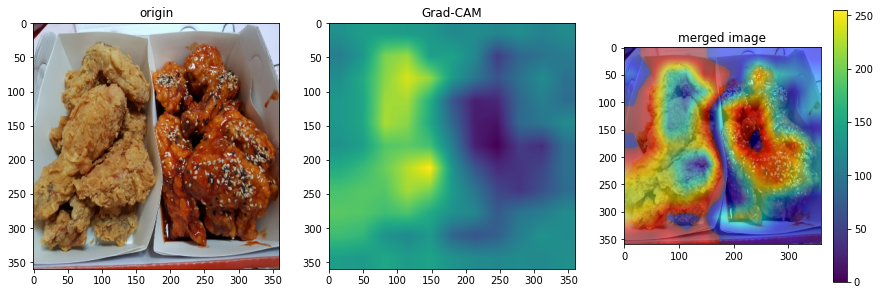

In [ ]:
VC.visualize_cam_on_image(fried, c_test)

In [ ]:
type(f_label)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
f_lbl = f_label.numpy().tolist()

In [ ]:
ldic = {}
for idx, lbl in enumerate(f_lbl[0]):
    ldic[idx] = lbl
ldic

{0: 2.7673124902705126e-10,
 1: 4.086666172565395e-13,
 2: 7.751026209756873e-11,
 3: 5.873647401788418e-11,
 4: 7.514261990415605e-10,
 5: 4.476586202423194e-13,
 6: 2.0384314236565615e-09,
 7: 2.1058563881210971e-16,
 8: 7.54799972524367e-11,
 9: 3.5819744392817654e-10,
 10: 2.893860937547288e-06,
 11: 5.407090952758153e-07,
 12: 2.2126666276121865e-13,
 13: 2.2251933842198923e-06,
 14: 1.0221473476295723e-16,
 15: 1.6916620881879396e-11,
 16: 1.1411430611216189e-12,
 17: 9.170964543336879e-10,
 18: 1.2536967020082557e-09,
 19: 3.2143784856053514e-10,
 20: 7.282335845459897e-10,
 21: 0.9823302030563354,
 22: 2.6712197043069277e-14,
 23: 2.0811529582998034e-11,
 24: 1.1556944912172185e-07,
 25: 5.361497480520488e-15,
 26: 1.0432623653855444e-08,
 27: 3.966318939951918e-11,
 28: 3.748149360327524e-12,
 29: 0.017663925886154175}

In [ ]:
sorted(list(ldic.items()), key=lambda x : x[1], reverse=True)


[(21, 0.9823302030563354),
 (29, 0.017663925886154175),
 (10, 2.893860937547288e-06),
 (13, 2.2251933842198923e-06),
 (11, 5.407090952758153e-07),
 (24, 1.1556944912172185e-07),
 (26, 1.0432623653855444e-08),
 (6, 2.0384314236565615e-09),
 (18, 1.2536967020082557e-09),
 (17, 9.170964543336879e-10),
 (4, 7.514261990415605e-10),
 (20, 7.282335845459897e-10),
 (9, 3.5819744392817654e-10),
 (19, 3.2143784856053514e-10),
 (0, 2.7673124902705126e-10),
 (2, 7.751026209756873e-11),
 (8, 7.54799972524367e-11),
 (3, 5.873647401788418e-11),
 (27, 3.966318939951918e-11),
 (23, 2.0811529582998034e-11),
 (15, 1.6916620881879396e-11),
 (28, 3.748149360327524e-12),
 (16, 1.1411430611216189e-12),
 (5, 4.476586202423194e-13),
 (1, 4.086666172565395e-13),
 (12, 2.2126666276121865e-13),
 (22, 2.6712197043069277e-14),
 (25, 5.361497480520488e-15),
 (7, 2.1058563881210971e-16),
 (14, 1.0221473476295723e-16)]